<a href="https://www.kaggle.com/code/abrachan/plant-seedlings-classification-by-ml?scriptVersionId=127540142" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<br>

# Introduction

This notebook is referenced from <a href="https://github.com/friedrichor/Plant-Seedlings-Classification" style="text-decoration:none">this one</a> and <a href="https://blog.csdn.net/Friedrichor/article/details/122248139" style="text-decoration:none">the matching illustrative blog</a> (in Chinese). The referenced nothbook only use the machine learning algorithms to predict the features extracted from the images using traditional image processing methods, but not predict by deep learning algorithm. The reason for the author to do so was that he or she just wanted to be farmiliar with these ML algoritms and image processing methods by implemented them. And so do I. And code in this notebook is a little different from the original one.

However, The original notebook just developed up to the training stage using stacking model with cross-validation, and the average accuracy is nearly 90%, so as mine. But when I go further with the predicting stage by myself and do a late submission, I got both the public score and private score as 0.24874. The result is so fuastrating. I initially think tthat here might be some mistakes in my reimplemented code. Since the purose of the author and me had been achieved, so I do not move forward to figure it out why the submission scores are so low.

I also submitted an result latebly obtained by using Deep Learning algorithm using tf.keras, referenced form <a href="https://www.kaggle.com/code/larsmadsen/tf-keras-inception-resnet-v2-97-acc" style="text-decoration:none">this notebook</a>, which achieved scores of 0.97984 but with very little code.

# Import Libraries

In [1]:
import os
import time
import random
import joblib
from collections import Counter
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from skimage import feature as ft

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb


import warnings
warnings.filterwarnings("ignore")

In [2]:
data_dir = "/kaggle/input/plant-seedlings-classification/"

class_names = os.listdir(data_dir + "train/")
classes_dict = dict()

for i, name in enumerate(class_names):
    classes_dict[name] = i
classes_dict

{'Scentless Mayweed': 0,
 'Common wheat': 1,
 'Charlock': 2,
 'Black-grass': 3,
 'Sugar beet': 4,
 'Loose Silky-bent': 5,
 'Maize': 6,
 'Cleavers': 7,
 'Common Chickweed': 8,
 'Fat Hen': 9,
 'Small-flowered Cranesbill': 10,
 'Shepherds Purse': 11}

# Image Processing

## `equalize()`: Histogram Equalization (直方图均衡)

In [3]:
# Image Histogram Equalization
def equalize(img):
    """Parameter `img` is read by cv2.imread(), so it is in BGR mode"""
    
    b, g, r = cv2.split(img)    # The image read by cv2.imread() is in BGR mode
    
    # Histogram Equalization channel by channel saperately
    b = cv2.equalizeHist(b)
    g = cv2.equalizeHist(g)    
    r = cv2.equalizeHist(r)
    
    img_equalized = cv2.merge((b, g, r))
    
    return img_equalized

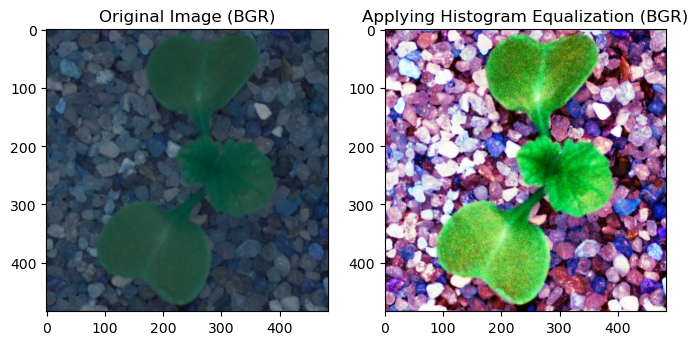

In [4]:
## TEST

img_bgr_try = cv2.imread(data_dir + "train/Charlock/0a7e1ca41.png")
img_equalized = equalize(img_bgr_try)

fig  = plt.figure(figsize=(8, 16))
ax1 = plt.subplot(121)
ax1.imshow(img_bgr_try)
ax1.set_title("Original Image (BGR)")
ax2 = plt.subplot(122)
ax2.imshow(img_equalized)
ax2.set_title("Applying Histogram Equalization (BGR)")
plt.show()

## `extract_seedling()`: Extracting Seedling (green parts)

In [5]:
def extract_seedling(img):
    """Parameter `img` is read by cv2.imread(), so it is in BGR mode"""
    
    # Green color range
    green_lower = np.array([35, 43, 46], dtype="uint8")   # Lower bound
    green_upper = np.array([90, 255, 255], dtype="uint8") # Upper bound
    
    # Gaussian filtering
    img_gaussed = cv2.GaussianBlur(img, (3, 3), 0)
    img_gaussed = cv2.cvtColor(img_gaussed, cv2.COLOR_BGR2HSV)
    
    # Binarization to create mask
    mask = cv2.inRange(img_gaussed, green_lower, green_upper)
    
    img_extracted = cv2.bitwise_and(img, img, mask=mask)
    
    return img_extracted

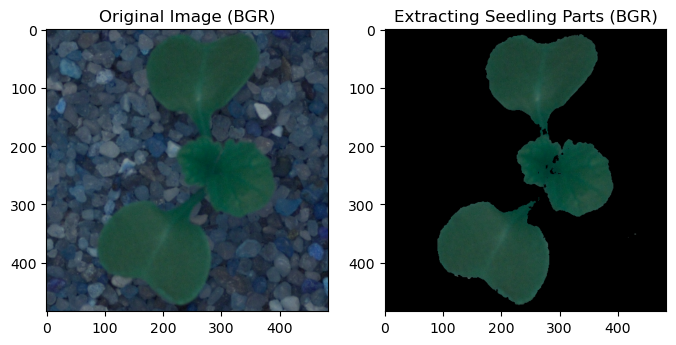

In [6]:
## TEST

img_bgr_try = cv2.imread(data_dir + "train/Charlock/0a7e1ca41.png")
img_extracted = extract_seedling(img_bgr_try)

fig  = plt.figure(figsize=(8, 16))
ax1 = plt.subplot(121)
ax1.imshow(img_bgr_try)
ax1.set_title("Original Image (BGR)")
ax2 = plt.subplot(122)
ax2.imshow(img_extracted)
ax2.set_title("Extracting Seedling Parts (BGR)")
plt.show()

## `preprocessing_imgs()`

This function is almost the same as `process()` in the referenced notebook, but I comment out the codes that to store the preprocessed images.

In [7]:
def preprocessing_imgs(file_dir):
    """Preprocess train image by applying equalize() and then extract_seedling().
       Store the preprocessed images in train_preprocessed folder and get their class labels."""
    
    images_list = []
    labels_list = []
    
    classes = os.listdir(file_dir)
    # print(classes)
    
    for cls in classes:
        img_names = os.listdir(file_dir + cls)
        # cls_folder = train_preprocessed_dir + cls
        # if not os.path.exists(cls_folder):
        #     os.makedirs(cls_folder)        # Create class folder if it does not exist
            
        for img_name in img_names:
            img_bgr = cv2.imread(file_dir + cls + '/' + img_name)
            img_equalized = equalize(img_bgr)
            img_seedling = extract_seedling(img_equalized)
            # cv2.imwrite(cls_folder + '/' + img_name, img_seedling)
            
            images_list.append(img_seedling)
            labels_list.append(classes_dict[cls])

    return images_list, labels_list

In [8]:
images_list, labels_list = preprocessing_imgs(data_dir + "train/")
num_per_class = Counter(labels_list)
num_per_class

Counter({0: 516,
         1: 221,
         2: 390,
         3: 263,
         4: 385,
         5: 654,
         6: 221,
         7: 287,
         8: 611,
         9: 475,
         10: 496,
         11: 231})

In [9]:
all_label = np.array(labels_list)

print(f'图像数量: {len(images_list)}')                 # 4750
print(f'第一张图片的shape: {images_list[0].shape}')    # (w, h, 3)
print(f'label数量: {all_label.shape[0]}')              # 4750

图像数量: 4750
第一张图片的shape: (142, 142, 3)
label数量: 4750


<br>

## ~`read_images_processed()`~

<br>

## `resize_imgs()`

In [10]:
def resize_imgs(images_list):
    """Resize images into the shape as (128, 128, 3) to ensure that they have the same shape."""
    
    imgs_list = []
    for image in images_list:
        image = cv2.resize(image, (128, 128)) 
        imgs_list.append(image)
    return imgs_list

<br>

# Features Extraction and Processing

<br>

## Helper Functions

### fill_missing()

In [11]:
# 填充缺失值
def fill_missing(feature):
    feature_df = pd.DataFrame(feature)      # 转为 DataFrame 格式，才能使用 fillna 函数
    feature_df_fill = feature_df.fillna(0)  # 将缺失值部分填充0
    
    return np.array(feature_df_fill)        # 返回array格式

<br>

### normalize()

In [12]:
# 标准化
def normalize(feature):
    scaler = StandardScaler()
    scaler.fit(feature)
    feature_normal = scaler.transform(feature)
    
    return feature_normal

<br>

### dimensionalityReduction()


由于提取出的 HOG，LBP 的特征维数很大，如果直接使用全部的特征矩阵作为训练集特征，训练速度很慢，且他们作为特征的占比过多，会影响到训练效果，导致准确率不高，因此需要使用主成分分析（PCA）对特征进行降维。

其中 `estimator.explained_variance_ratio_` 表示降维后每个维度能代表原先特征的占比，遍历并对其累加输出，方便确定一个好的降维维度数，使其维度不太多且能代表原先特征的较高占比，尽量减少降维所造成的特征损失。


In [13]:
# Use PCA(Principal Component Analysis) to reduce dimensionality
def dimensionalityReduction(feature, n=100, is_whiten=False, is_show=True):
    estimator = PCA(n_components=n, whiten=is_whiten)
    pca_feature = estimator.fit_transform(feature)
    
    sum = 0
    for ratio in estimator.explained_variance_ratio_:
        sum += ratio
        if is_show:
            print(sum)
    
    print('降维后特征矩阵shape为:', pca_feature.shape)
    print('主成分比例为:', sum)
    
    return pca_feature

<br>

### save_feature()

In [14]:
print(os.getcwd())

os.makedirs("./save_features", exist_ok=True)

/kaggle/working


In [15]:
feature_dir = "./save_features/"

# 将提取出的特征数组（二维）保存到npy文件中
def save_feature(feature, fileName):
    np.save(feature_dir + fileName + '.npy', feature, allow_pickle=True)
    
    print(fileName + '.npy', '文件已生成！')

<br>

### read_feature()

In [16]:
feature_dir = "./save_features/"

# 读取之前保存好的 feature 文件，返回特征矩阵（二维数组）
def read_feature(fileName):
    feature = np.load(feature_dir + fileName + '.npy', allow_pickle=True)
    print('已读取', fileName, '文件！\t shape = ', feature.shape)

    return feature

<br>
<br>

## Features Extraction

### SIFT + BOW

#### SIFT

In [17]:
def sift_feature(images_list):
    """Extract SIFT feature of the image"""
    
    feature_sift_list = []  # SIFT特征向量列表
    
    # sift = cv2.xfeatures2d.SIFT_create()   # old-version cv2
    sift = cv2.SIFT_create()
    
    for i in tqdm(range(len(images_list))):
        image = cv2.cvtColor(images_list[i], cv2.COLOR_BGR2GRAY)
        
        # Obtain SIFT feature，kp is keypoints，des is descriptors (feature vectors)
        kp, des = sift.detectAndCompute(image, None)
        feature_sift_list.append(des)
        
    return feature_sift_list

kp[0] = <KeyPoint 0x7f68c732e360>
len(kp) = 150
des.shape = (150, 128)


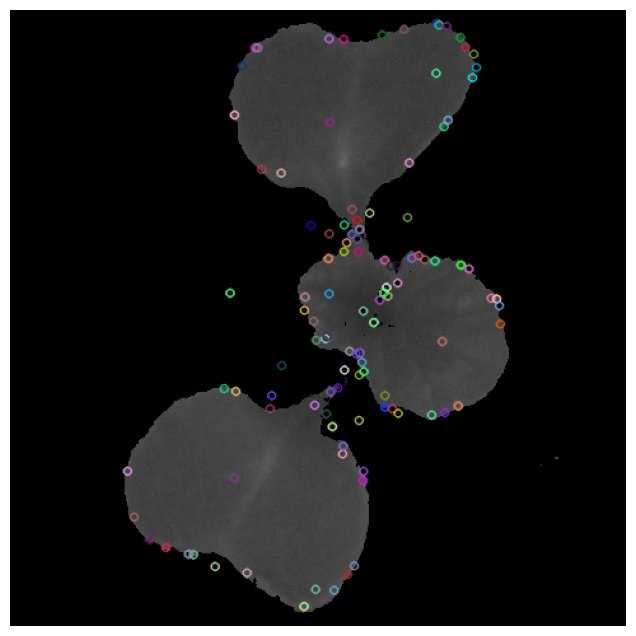

CPU times: user 526 ms, sys: 210 ms, total: 735 ms
Wall time: 401 ms


In [18]:
%%time

## TEST SIFT
sift = cv2.SIFT_create()

img_extracted_gray = cv2.cvtColor(img_extracted, cv2.COLOR_BGR2GRAY)

kp = sift.detect(img_extracted_gray, None)   #  找到关键点

# 绘制关键点 
img_kp_gray = cv2.drawKeypoints(img_extracted_gray, kp, img_extracted_gray)

# 计算关键点对应的sift特征向量
# kp为关键点列表，des为numpy的数组，为 (关键点数目,128)
kp, des = sift.compute(img_kp_gray, kp)

print('kp[0] =', kp[0])
print('len(kp) =', len(kp))
print('des.shape =', des.shape)

plt.figure(figsize=(8,8))
plt.imshow(img_kp_gray)
plt.axis('off')
plt.show()

In [19]:
%%time

# 获取 SIFT 特征列表
feature_sift_list = sift_feature(images_list)

100%|██████████| 4750/4750 [06:16<00:00, 12.63it/s]

CPU times: user 9min 14s, sys: 1min 21s, total: 10min 35s
Wall time: 6min 16s


In [20]:
print(len(feature_sift_list))     # 4750
print(feature_sift_list[0])
print()

# 以下3个输出为sift特征的 shape, 为 (关键点数量, 128)
print(feature_sift_list[0].shape)      # (?, 128)
print(feature_sift_list[1].shape)      # (?, 128)
print(feature_sift_list[100].shape)    # (?, 128)

4750
[[ 0.  0.  0. ...  0.  0. 12.]
 [ 0.  0.  1. ...  0.  0.  0.]
 [ 5.  0.  0. ...  0.  0.  0.]
 ...
 [ 5.  0.  0. ...  2.  1.  3.]
 [ 4.  0.  0. ...  1.  0. 10.]
 [ 7.  0.  0. ...  0.  3.  6.]]

(57, 128)
(133, 128)
(56, 128)


<br>

#### BOW

In [21]:
## Initialize BOW Trainer

def bow_init(feature_sift_list):
    """Initialize BOW trainer"""
    
    ## 创建BOW训练器，指定 k-means 参数 k 把处理好的特征数据全部合并，利用聚类把特征词分为若干类，
    ## 此若干类的数目由自己设定，每一类相当于一个视觉词汇
    bow_kmeans_trainer = cv2.BOWKMeansTrainer(100)    # 100 个词汇
    
    for feature_sift in feature_sift_list:
        bow_kmeans_trainer.add(feature_sift)
    
    # 进行k-means聚类，返回词汇字典 也就是聚类中心
    voc = bow_kmeans_trainer.cluster()
    
    # 输出词汇字典
    print("In bow_init(), print variable `voc`: ")
    print(type(voc), voc.shape)    # <class 'numpy.ndarray'> (100, 128)
    print(voc)
    print()
    
    # FLANN 匹配  
    # algorithm 用来指定匹配所使用的算法，可以选择的有 LinearIndex、KTreeIndex、KMeansIndex、CompositeIndex 和 AutotuneIndex
    # 这里选择的是 KTreeIndex (使用 kd树 实现最近邻搜索)
    flann_params = dict(algorithm=1, tree=5)           # define parameters for cv2.FlannBasedMatcher()
    flann = cv2.FlannBasedMatcher(flann_params,{})
    
    print(flann)
    
    #初始化 bow 提取器(设置词汇字典),用于提取每一张图像的BOW特征描述
    # sift = cv2.xfeatures2d.SIFT_create()   # old-version cv2
    sift = cv2.SIFT_create()
    bow_img_descriptor_extractor = cv2.BOWImgDescriptorExtractor(sift, flann)        
    bow_img_descriptor_extractor.setVocabulary(voc)
    
    print(bow_img_descriptor_extractor)
    
    return bow_img_descriptor_extractor

In [22]:
## Extract BOW Features
def bow_feature(bow_img_descriptor_extractor, images_list):
    # 分别对每个图片提取BOW特征，获得BOW特征列表
    feature_bow_list = []
    
    # sift = cv2.xfeatures2d.SIFT_create()   # old-version cv2
    sift = cv2.SIFT_create()
    for i in tqdm(range(len(images_list))):
        image = cv2.cvtColor(images_list[i], cv2.COLOR_BGR2GRAY)
        feature_bow = bow_img_descriptor_extractor.compute(image,sift.detect(image))
        feature_bow_list.append(feature_bow)
        
    return np.array(feature_bow_list)[:,0,:]

<br>

In [23]:
%%time
## 获取 SIFT + BOW 特征

# 从图像中提取并保存在npy文件中
bow_extractor = bow_init(feature_sift_list)
all_feature_bow = bow_feature(bow_extractor, images_list)  # shape = (4750, 100)
# save_feature(all_feature_bow, 'all_feature_bow')

In bow_init(), print variable `voc`: 
<class 'numpy.ndarray'> (100, 128)
[[40.64885   49.652336  23.08815   ... 46.18196   18.555628   8.561357 ]
 [ 4.008064   2.7493377  2.4037554 ...  8.022347   3.0938256  5.316784 ]
 [45.312298  29.563457   6.8876553 ... 49.915295   6.6516747  3.3781214]
 ...
 [27.211706  24.643587  24.803078  ... 24.246801  22.526583  21.182833 ]
 [15.448592  13.465574  10.092813  ... 46.613453   4.6946616  4.1199665]
 [21.065887  15.793456  11.514842  ... 14.486058  10.181021  10.438723 ]]

<FlannBasedMatcher 0x7f68c6d233b0>
<BOWImgDescriptorExtractor 0x7f68c7329cd0>


100%|██████████| 4750/4750 [11:18<00:00,  7.00it/s]  

CPU times: user 53min 56s, sys: 2min 18s, total: 56min 14s
Wall time: 21min 41s


<br>

### HOG

In [24]:
# 所有图片 resize 成(128,128)，保证每个图像提取出的 HOG，LBP 特征数量一致
# 提取 HOG，LBP 特征前调用
images_list = resize_imgs(images_list)

In [25]:
# 提取 HOG 特征
def hog_feature(image_list):
    feature_hog_list = []
    for i in tqdm(range(len(image_list))):  # ft is short for skimage.feature
        feature_hog = ft.hog(image_list[i], 
                             orientations=16, 
                             pixels_per_cell=(32, 32), 
                             cells_per_block=(3, 3), 
                             feature_vector=True, 
                             multichannel=True)
        feature_hog_list.append(feature_hog)
    
    return np.array(feature_hog_list)

In [26]:
%%time

## 获取 HOG 特征
## 从图像中提取并保存在 csv 文件中
all_feature_hog = hog_feature(images_list)

# print('all_feature_hog.shape =', all_feature_hog.shape)
# save_feature(all_feature_hog, 'all_feature_hog')

100%|██████████| 4750/4750 [00:17<00:00, 277.49it/s]

CPU times: user 17.1 s, sys: 88.8 ms, total: 17.2 s
Wall time: 17.1 s


24336


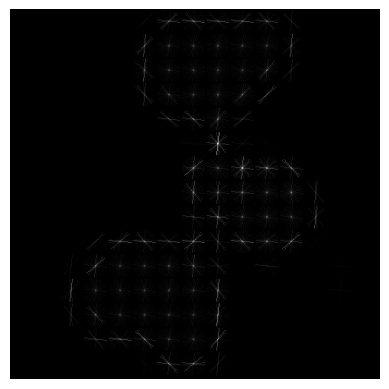

In [27]:
# TEST HOG
feature_hog = ft.hog(img_extracted, 
                     orientations=16, 
                     pixels_per_cell=(32, 32), 
                     cells_per_block=(3, 3), 
                     feature_vector=True,
                     multichannel=True, 
                     visualize=True)
print(feature_hog[0].shape[0])
plt.imshow(feature_hog[1], cmap=plt.cm.gray)
plt.axis('off')
plt.show()

<br>

### LBP

In [28]:
# 提取 LBP 特征
def lbp_feature(images_list):
    feature_lbp_list = []
    for j in tqdm(range(len(images_list))):
        feature_lbp = []
        image = images_list[j]
        for i in range(3):
            feature_lbp.append(ft.local_binary_pattern(np.array(image[:,:,i]), 64, 64, 'var'))
        feature_lbp_list.append(feature_lbp)
    return np.array(feature_lbp_list)

In [29]:
%%time

## 获取 LBP 特征
all_feature_lbp = lbp_feature(images_list)    # shape = (4750, 3, 128, 128)
print(np.array(all_feature_lbp).shape)        # (4750, 3, 128, 128)



## 将四维转为二维
all_feature_lbp = all_feature_lbp.reshape(all_feature_lbp.shape[0], 
                                          all_feature_lbp.shape[1] * all_feature_lbp.shape[2] * all_feature_lbp.shape[3])

print('all_feature_lbp.shape =', all_feature_lbp.shape)  # (4750, 49152)

100%|██████████| 4750/4750 [04:50<00:00, 16.37it/s]


(4750, 3, 128, 128)
all_feature_lbp.shape = (4750, 49152)
CPU times: user 4min 51s, sys: 4.27 s, total: 4min 55s
Wall time: 4min 54s


In [30]:
# TEST LBP
feature_lbp = []
for i in range(3):
    feature_lbp.append(ft.local_binary_pattern(img_extracted[:,:,i], 64, 64, 'var'))
print(feature_lbp)    # list of ndarray
print()

feature_lbp_array = np.array(feature_lbp)
print(feature_lbp_array.shape)

# 挑选出非 nan 值
feature_lbp_array[np.logical_not(np.isnan(feature_lbp_array))]

[array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]]), array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]]), array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])]

(3, 484, 484)


array([  2.48161859,  33.90752865,  33.97741237, ..., 323.32593485,
       183.73585783,  24.47779017])

<br>
<br>

## Features Processing

### Deal with Missing Values

In [31]:
## 填充缺失值
all_feature_lbp = fill_missing(all_feature_lbp)  
# save_feature(all_feature_lbp, 'all_feature_lbp')

### Standardize

In [32]:
%%time
all_feature_bow_normal = normalize(all_feature_bow)
save_feature(all_feature_bow_normal, 'all_feature_bow_normal')

all_feature_hog_normal = normalize(all_feature_hog)
save_feature(all_feature_hog_normal, 'all_feature_hog_normal')

all_feature_lbp_normal = normalize(all_feature_lbp)
save_feature(all_feature_lbp_normal, 'all_feature_lbp_normal')

all_feature_bow_normal.npy 文件已生成！
all_feature_hog_normal.npy 文件已生成！
all_feature_lbp_normal.npy 文件已生成！
CPU times: user 3.46 s, sys: 6.38 s, total: 9.84 s
Wall time: 9.85 s


<br>

### Dimensionality Reduction

In [33]:
%%time

print('all_feature_bow.shape =', all_feature_bow.shape)    # all_feature_hog.shape = (4750, 100)
pca_feature_bow = dimensionalityReduction(all_feature_bow, 100)
print('pca_feature_bow.shape =', pca_feature_bow.shape)    # pca_feature_hog.shape = (4750, 100)
save_feature(pca_feature_bow, 'pca_feature_bow')

all_feature_bow.shape = (4750, 100)
0.16587485373020172
0.2655452638864517
0.3506714776158333
0.41250599175691605
0.4554389640688896
0.4874797910451889
0.5134609173983335
0.5386642031371593
0.5587139036506414
0.5768079739063978
0.5942309461534023
0.6107800211757421
0.6260884683579206
0.6406862884759903
0.653700677677989
0.6662272633984685
0.6784443343058228
0.6899876547977328
0.7009683167561889
0.7111514825373888
0.7212033765390515
0.7310513332486153
0.7407767567783594
0.7497542565688491
0.7583428742364049
0.7666370701044798
0.7743386388756335
0.7820036853663623
0.7892151875421405
0.796275582164526
0.8030925933271646
0.8096006279811263
0.8160217562690377
0.8223858391866088
0.8286064108833671
0.8345529185608029
0.8401976409368217
0.8458254029974341
0.8511375184170902
0.8561576185747981
0.8610996291972697
0.8658991646952927
0.8705627713352442
0.8750339676626027
0.8793655778281391
0.8835036586970091
0.8873849974479526
0.8911798717454076
0.8948697778396308
0.8985299651976675
0.902108935872

In [34]:
%%time

print('all_feature_hog.shape =', all_feature_hog.shape)    # all_feature_hog.shape = (4750, 576)
pca_feature_hog = dimensionalityReduction(all_feature_hog, 100)
print('pca_feature_hog.shape =', pca_feature_hog.shape)    # pca_feature_hog.shape = (4750, 100)
save_feature(pca_feature_hog, 'pca_feature_hog')

all_feature_hog.shape = (4750, 576)
0.15830121856992538
0.2799529860681803
0.33597341138101944
0.3843279274594311
0.4311896486423861
0.47144552899032216
0.5029799453778128
0.5316928728703172
0.5593549775389028
0.5823184303999767
0.6023142122300449
0.6205612381414841
0.6376027348059655
0.6538082827152444
0.6683558519220645
0.6805147614874524
0.6925330485043303
0.7040154462363247
0.7145090704201562
0.7248411272174755
0.7349944006868626
0.7446318836443655
0.7540288515427188
0.762998657777932
0.7715509314245337
0.7786676689793262
0.7850821865753859
0.7908742226027794
0.7965132423622908
0.8018700868094527
0.8070829966280845
0.8120869567743569
0.8168942317953378
0.8213297643706561
0.8256598188865735
0.8299217516151521
0.8340744078234895
0.8380244638266121
0.8417912948958969
0.8455160760562234
0.8490524044784684
0.8525121784231287
0.855920327682454
0.8591230360926401
0.862277631539564
0.8653463583224243
0.8682367797979457
0.8710184873596876
0.8737021185522815
0.8762851457016407
0.878709983254

In [35]:
%%time

print('all_feature_lbp.shape =', all_feature_lbp.shape)  # all_feature_lbp.shape = (4750, 49152)
pca_feature_lbp = dimensionalityReduction(all_feature_lbp, 100, True)
print('pca_feature_lbp.shape =', pca_feature_lbp.shape)  # pca_feature_lbp.shape = (4750, 100)
save_feature(pca_feature_lbp, 'pca_feature_lbp')

all_feature_lbp.shape = (4750, 49152)
0.46478886719852364
0.5874154513214902
0.672293919396039
0.7159846150026709
0.7397150952933077
0.7573625991237934
0.7729804112417332
0.7882458674324315
0.8020680561275579
0.8153997707341849
0.8256859709561117
0.8348726068198832
0.8436432399197256
0.8522473959286075
0.8602287290135661
0.8652945298141959
0.870130883851614
0.8745783371802274
0.8781735124372373
0.8816812289258303
0.885087851847133
0.8882351556999377
0.8911728944303913
0.8939711195040704
0.8966516921255725
0.8991973393103637
0.901640680081655
0.9038143908903511
0.9059348744265412
0.9077615317035866
0.9095220548752699
0.9112188641717783
0.9128551115104594
0.9144527898080618
0.9159570825622568
0.9174490730728547
0.9188896870402489
0.9202272257408753
0.9215456686263924
0.9227814116361566
0.9239768770053316
0.9251357192128931
0.9262530727963939
0.927280005847593
0.9282591900796914
0.9292201192819517
0.9301586911475443
0.9310648169974802
0.9319360879848901
0.9327842810974446
0.93360068124074

<br>

## Concatenate All Features

In [37]:
# 将 SIFT+BOW, HOG, LBP 三种特征矩阵拼合到一起
# all_feature_list = [all_feature_bow_normal, pca_feature_hog, pca_feature_lbp]
all_feature_list = [pca_feature_bow, pca_feature_hog, pca_feature_lbp]

all_feature = [[] for i in range(4750)]  # 创建二维空数组，行数为 4750

for feature in all_feature_list:
    all_feature = np.hstack((all_feature, feature))
    
print(all_feature.shape)

np.save(feature_dir + 'all_feature', all_feature, allow_pickle=True)

(4750, 300)


<br>
<br>
<br>


# Train Models


## StratifiedShuffleSplit() 

**train_test_split()** 函数划分数据集是将所有数据同一划分训练集和验证集，这大概率会导致每一类数据在训练集和验证集的比例是不同的，数据集划分不平衡会导致训练模型时对于某一类的训练效果很好，而对另一类的训练效果很差，即出现了过拟合和欠拟合的情况。

<br>

**StratifiedShuffleSplit()** 函数将数据集“按类”划分训练集和验证集，保证每一类训练集和验证集的比例是相同的，有效降低了过拟合和欠拟合情况的出现。

In [38]:
# 按类划分数据集
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
sss.get_n_splits(all_feature, all_label)
for train_index, test_index in sss.split(all_feature, all_label):
    x_train, x_val = all_feature[train_index], all_feature[test_index]
    y_train, y_val = all_label[train_index], all_label[test_index]

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val  : ", x_val.shape)
print("y_val  : ", y_val.shape)

x_train:  (3800, 300)
y_train:  (3800,)
x_val  :  (950, 300)
y_val  :  (950,)


In [39]:
num_class_train = np.zeros(12, dtype=np.int64)
num_class_val = np.zeros(12, dtype=np.int64)
for y in y_train:
    num_class_train[y] += 1
for y in y_val:
    num_class_val[y] += 1
    
print('划分后训练集中各类的数量 =', num_class_train)
print('数据集中各类的数量 * 0.8 =', [round((i * 0.8), 1) for i in num_per_class.values()])
print('划分后验证集中各类的数量 =', num_class_val)
print('数据集中各类的数量 * 0.2 =', [round((i * 0.2), 1) for i in num_per_class.values()])

划分后训练集中各类的数量 = [413 177 312 210 308 523 177 229 489 380 397 185]
数据集中各类的数量 * 0.8 = [412.8, 176.8, 312.0, 210.4, 308.0, 523.2, 176.8, 229.6, 488.8, 380.0, 396.8, 184.8]
划分后验证集中各类的数量 = [103  44  78  53  77 131  44  58 122  95  99  46]
数据集中各类的数量 * 0.2 = [103.2, 44.2, 78.0, 52.6, 77.0, 130.8, 44.2, 57.4, 122.2, 95.0, 99.2, 46.2]


从上面的输出可以看出训练集与验证集的划分是符合“按类”划分的。

<br>
<br>

## Training

### category_show()

In [40]:
# 展示各类的准确率、召回率、f1-score，及混淆矩阵可视化
def category_show(model, x_val, y_val):
    target_names = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat',
                    'Fat Hen', 'Loose Silky-bent', 'Maize','Scentless Mayweed', 'Shepherds Purse', 
                    'Small-flowered Cranesbill', 'Sugar beet']
    y_pred = model.predict(x_val)
    
    print(classification_report(y_val, y_pred, target_names=target_names))
    cm = confusion_matrix(y_val, y_pred)
    cm_display = ConfusionMatrixDisplay(cm).plot()

<br>

### XGBoost 模型

In [41]:
%%time

# XGBoost 模型
model_xgb = XGBClassifier(# objective="multi:softmax",
                          objective='multi:softproba',
                          n_estimators=1000,
                          num_class=12,
                          learning_rate=0.1,
                          # tree_method='gpu_hist', 
                          # gpu_id=-1,
                          max_depth=3, 
                          min_child_weight=2, 
                          max_delta_step=3, 
                          subsample=0.7, 
                          gamma=0, 
                          n_jobs=-1,)

model_xgb.fit(x_train, y_train, 
              early_stopping_rounds=10, 
              eval_set=[(x_val, y_val)], 
              eval_metric='mlogloss', 
              verbose=50)
score_xgb = model_xgb.score(x_val, y_val)
print('score_xgb =', score_xgb)

[0]	validation_0-mlogloss:2.30889
[50]	validation_0-mlogloss:0.70943
[100]	validation_0-mlogloss:0.53317
[150]	validation_0-mlogloss:0.46176
[200]	validation_0-mlogloss:0.42802
[250]	validation_0-mlogloss:0.40999
[300]	validation_0-mlogloss:0.40102
[337]	validation_0-mlogloss:0.39633
score_xgb = 0.871578947368421
CPU times: user 10min 9s, sys: 1.45 s, total: 10min 10s
Wall time: 2min 38s


                           precision    recall  f1-score   support

              Black-grass       0.82      0.88      0.85       103
                 Charlock       0.79      0.70      0.75        44
                 Cleavers       0.94      0.95      0.94        78
         Common Chickweed       0.72      0.53      0.61        53
             Common wheat       0.96      0.86      0.90        77
                  Fat Hen       0.84      0.92      0.88       131
         Loose Silky-bent       1.00      0.86      0.93        44
                    Maize       0.88      0.79      0.84        58
        Scentless Mayweed       0.88      0.93      0.90       122
          Shepherds Purse       0.81      0.96      0.88        95
Small-flowered Cranesbill       0.95      0.97      0.96        99
               Sugar beet       0.87      0.74      0.80        46

                 accuracy                           0.87       950
                macro avg       0.87      0.84      0.85    

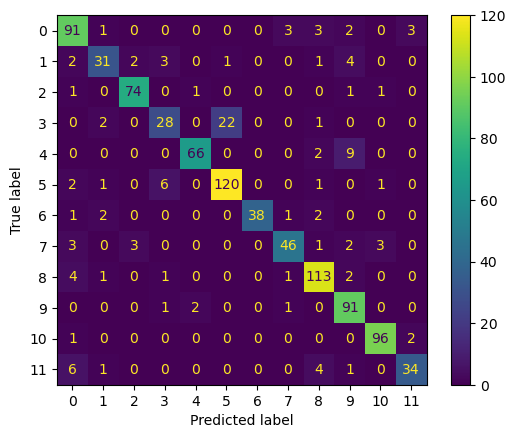

In [42]:
category_show(model_xgb, x_val, y_val)

<br>

### LightGBM 模型

In [43]:
%%time

# LightGBM 模型
model_lgb = lgb.LGBMClassifier(learning_rate=0.1, 
                               objective='multiclass', 
                               num_class=12, 
                               n_estimators=1500, 
                               max_depth=3, 
                               sub_sample=0.7, 
                               n_jobs=-1)
model_lgb.fit(x_train, y_train, 
              early_stopping_rounds=10, 
              eval_set=[(x_val, y_val)], 
              eval_metric ='logloss', 
              verbose=10)
score_lgb = model_lgb.score(x_val, y_val)
print('score_lgb =', score_lgb)

[LightGBM] [Warning] Unknown parameter: sub_sample
[10]	valid_0's multi_logloss: 1.14074
[20]	valid_0's multi_logloss: 0.835376
[30]	valid_0's multi_logloss: 0.695522
[40]	valid_0's multi_logloss: 0.6218
[50]	valid_0's multi_logloss: 0.570946
[60]	valid_0's multi_logloss: 0.538299
[70]	valid_0's multi_logloss: 0.512708
[80]	valid_0's multi_logloss: 0.495199
[90]	valid_0's multi_logloss: 0.481828
[100]	valid_0's multi_logloss: 0.470721
[110]	valid_0's multi_logloss: 0.460499
[120]	valid_0's multi_logloss: 0.454866
[130]	valid_0's multi_logloss: 0.449459
[140]	valid_0's multi_logloss: 0.447336
[150]	valid_0's multi_logloss: 0.445975
[160]	valid_0's multi_logloss: 0.446885
score_lgb = 0.8663157894736843
CPU times: user 40.1 s, sys: 1.59 s, total: 41.6 s
Wall time: 12.7 s


                           precision    recall  f1-score   support

              Black-grass       0.85      0.90      0.87       103
                 Charlock       0.85      0.66      0.74        44
                 Cleavers       0.95      0.94      0.94        78
         Common Chickweed       0.74      0.53      0.62        53
             Common wheat       0.93      0.87      0.90        77
                  Fat Hen       0.82      0.92      0.87       131
         Loose Silky-bent       0.97      0.89      0.93        44
                    Maize       0.86      0.76      0.81        58
        Scentless Mayweed       0.86      0.89      0.87       122
          Shepherds Purse       0.79      0.97      0.87        95
Small-flowered Cranesbill       0.96      0.97      0.96        99
               Sugar beet       0.85      0.72      0.78        46

                 accuracy                           0.87       950
                macro avg       0.87      0.83      0.85    

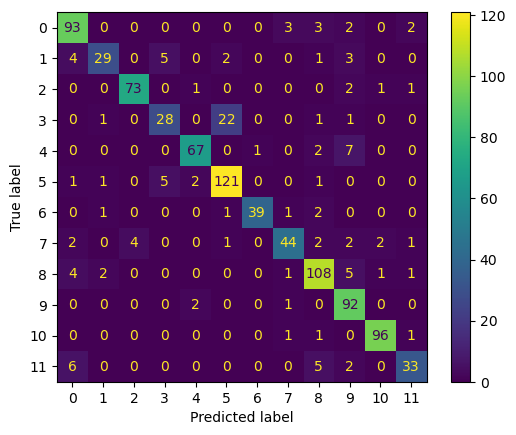

In [44]:
category_show(model_lgb, x_val, y_val)

<br>

### GBDT 模型

In [45]:
%%time

# GBDT模型
model_gbdt = GradientBoostingClassifier(learning_rate=0.1, n_estimators=500, max_depth=3)
model_gbdt.fit(x_train, y_train)
score_gbdt = model_gbdt.score(x_val, y_val)
print('score_gbdt =', score_gbdt)

score_gbdt = 0.8463157894736842
CPU times: user 39min 45s, sys: 253 ms, total: 39min 45s
Wall time: 39min 46s


                           precision    recall  f1-score   support

              Black-grass       0.82      0.88      0.85       103
                 Charlock       0.78      0.66      0.72        44
                 Cleavers       0.92      0.91      0.92        78
         Common Chickweed       0.56      0.42      0.48        53
             Common wheat       0.90      0.84      0.87        77
                  Fat Hen       0.81      0.92      0.86       131
         Loose Silky-bent       0.88      0.84      0.86        44
                    Maize       0.89      0.83      0.86        58
        Scentless Mayweed       0.84      0.86      0.85       122
          Shepherds Purse       0.81      0.91      0.86        95
Small-flowered Cranesbill       0.99      0.96      0.97        99
               Sugar beet       0.81      0.74      0.77        46

                 accuracy                           0.85       950
                macro avg       0.84      0.81      0.82    

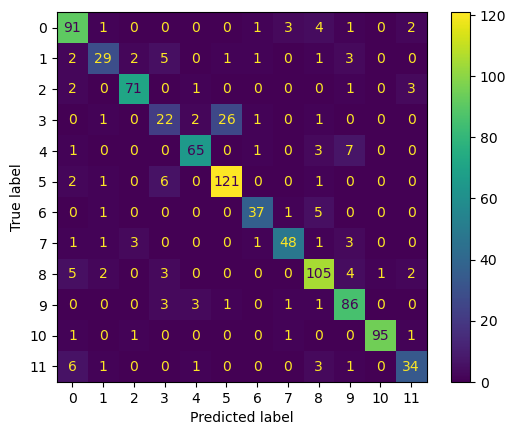

In [46]:
category_show(model_gbdt, x_val, y_val)

<br>

### RandomForest 模型

In [47]:
%%time

# RandomForest 模型
model_rf = RandomForestClassifier(n_estimators=150, n_jobs=-1)
model_rf.fit(x_train, y_train)
score_rf = model_rf.score(x_val, y_val)
print('score_rf =', score_rf)

score_rf = 0.7936842105263158
CPU times: user 9.31 s, sys: 5.11 ms, total: 9.31 s
Wall time: 9.31 s


                           precision    recall  f1-score   support

              Black-grass       0.79      0.83      0.81       103
                 Charlock       0.89      0.55      0.68        44
                 Cleavers       0.82      0.96      0.89        78
         Common Chickweed       0.71      0.19      0.30        53
             Common wheat       0.83      0.83      0.83        77
                  Fat Hen       0.73      0.97      0.83       131
         Loose Silky-bent       1.00      0.52      0.69        44
                    Maize       0.88      0.76      0.81        58
        Scentless Mayweed       0.70      0.86      0.77       122
          Shepherds Purse       0.78      0.88      0.83        95
Small-flowered Cranesbill       0.88      0.99      0.93        99
               Sugar beet       0.93      0.30      0.46        46

                 accuracy                           0.79       950
                macro avg       0.83      0.72      0.74    

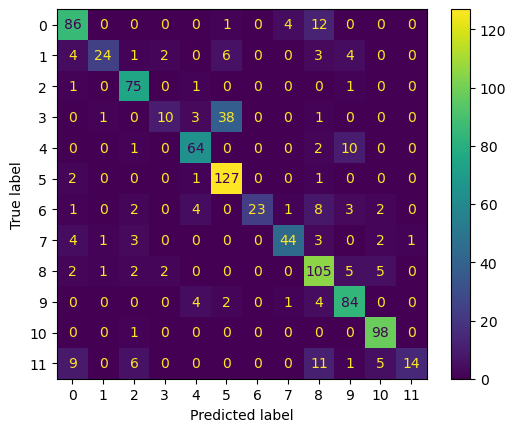

In [48]:
category_show(model_rf, x_val, y_val)

<br>

### SVC 模型

In [49]:
%%time

# SVC 模型
model_SVC = SVC(C=1)
model_SVC.fit(x_train, y_train)
score_SVC = model_SVC.score(x_val, y_val)
print('score_SVC =', score_SVC)

score_SVC = 0.6905263157894737
CPU times: user 4.52 s, sys: 64 µs, total: 4.52 s
Wall time: 4.52 s


                           precision    recall  f1-score   support

              Black-grass       0.60      0.74      0.66       103
                 Charlock       0.50      0.11      0.19        44
                 Cleavers       0.80      0.78      0.79        78
         Common Chickweed       0.00      0.00      0.00        53
             Common wheat       0.71      0.71      0.71        77
                  Fat Hen       0.51      0.89      0.65       131
         Loose Silky-bent       0.69      0.50      0.58        44
                    Maize       0.91      0.72      0.81        58
        Scentless Mayweed       0.75      0.84      0.80       122
          Shepherds Purse       0.76      0.77      0.76        95
Small-flowered Cranesbill       0.83      0.83      0.83        99
               Sugar beet       0.95      0.43      0.60        46

                 accuracy                           0.69       950
                macro avg       0.67      0.61      0.61    

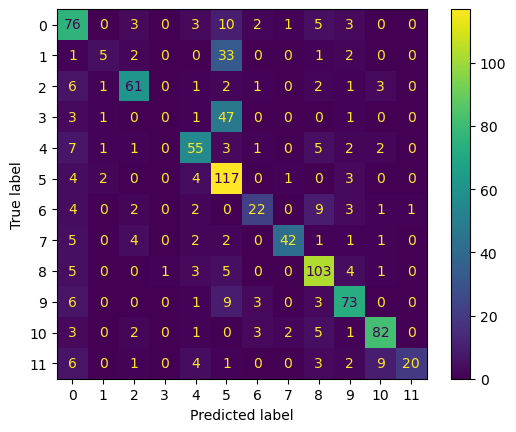

In [50]:
category_show(model_SVC, x_val, y_val)

<br>

### KNN 模型

In [52]:
model_knn = KNeighborsClassifier(n_neighbors=1)
model_knn.fit(x_train, y_train)
score_knn = model_knn.score(x_val, y_val)
print('score_knn =', score_knn)

score_knn = 0.5178947368421053


                           precision    recall  f1-score   support

              Black-grass       0.65      0.46      0.54       103
                 Charlock       0.19      0.30      0.23        44
                 Cleavers       0.71      0.45      0.55        78
         Common Chickweed       0.18      0.38      0.24        53
             Common wheat       0.63      0.52      0.57        77
                  Fat Hen       0.34      0.56      0.42       131
         Loose Silky-bent       0.71      0.34      0.46        44
                    Maize       0.53      0.57      0.55        58
        Scentless Mayweed       0.78      0.73      0.75       122
          Shepherds Purse       0.58      0.55      0.57        95
Small-flowered Cranesbill       0.88      0.68      0.77        99
               Sugar beet       0.73      0.17      0.28        46

                 accuracy                           0.52       950
                macro avg       0.58      0.47      0.49    

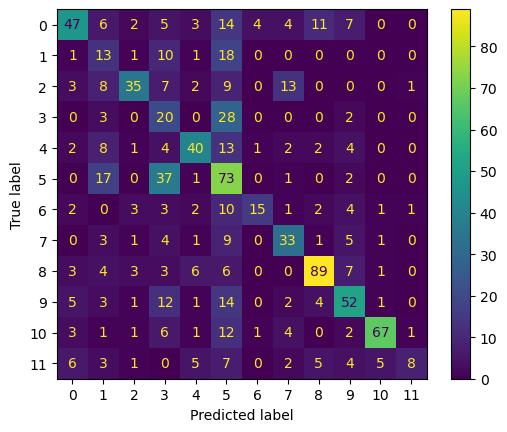

In [53]:
category_show(model_knn, x_val, y_val)

<br>

### SGD 模型

In [54]:
%%time

model_sgdc = SGDClassifier(max_iter=1000, tol=1e-3)
model_sgdc.fit(x_train, y_train)
score_sgdc = model_sgdc.score(x_val, y_val)
print('score_sgdc =', score_sgdc)

score_sgdc = 0.7294736842105263
CPU times: user 2.09 s, sys: 6.97 ms, total: 2.1 s
Wall time: 2.09 s


                           precision    recall  f1-score   support

              Black-grass       0.66      0.65      0.66       103
                 Charlock       0.56      0.41      0.47        44
                 Cleavers       0.68      0.78      0.73        78
         Common Chickweed       0.65      0.38      0.48        53
             Common wheat       0.69      0.77      0.72        77
                  Fat Hen       0.71      0.86      0.78       131
         Loose Silky-bent       0.70      0.64      0.67        44
                    Maize       0.72      0.71      0.71        58
        Scentless Mayweed       0.87      0.85      0.86       122
          Shepherds Purse       0.75      0.72      0.73        95
Small-flowered Cranesbill       0.86      0.86      0.86        99
               Sugar beet       0.66      0.63      0.64        46

                 accuracy                           0.73       950
                macro avg       0.71      0.69      0.69    

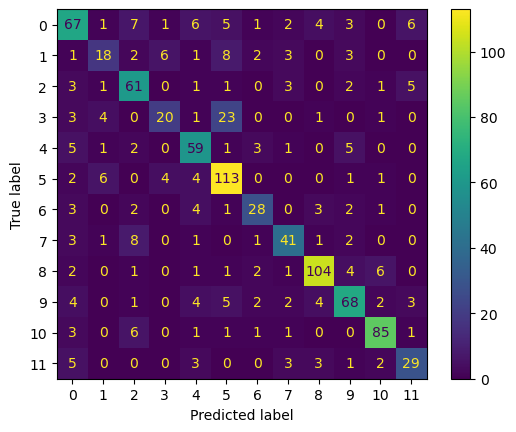

In [55]:
category_show(model_sgdc, x_val, y_val)

<br>

### ExtraTrees 模型

In [56]:
model_ET = ExtraTreesClassifier()
model_ET.fit(x_train, y_train)
score_ET = model_ET.score(x_val, y_val)
print('score_ET =', score_ET)

score_ET = 0.7863157894736842


                           precision    recall  f1-score   support

              Black-grass       0.76      0.84      0.80       103
                 Charlock       0.94      0.34      0.50        44
                 Cleavers       0.85      0.96      0.90        78
         Common Chickweed       0.75      0.17      0.28        53
             Common wheat       0.82      0.81      0.81        77
                  Fat Hen       0.69      0.98      0.81       131
         Loose Silky-bent       1.00      0.55      0.71        44
                    Maize       0.85      0.71      0.77        58
        Scentless Mayweed       0.72      0.86      0.78       122
          Shepherds Purse       0.83      0.92      0.87        95
Small-flowered Cranesbill       0.82      0.98      0.89        99
               Sugar beet       1.00      0.37      0.54        46

                 accuracy                           0.79       950
                macro avg       0.84      0.71      0.72    

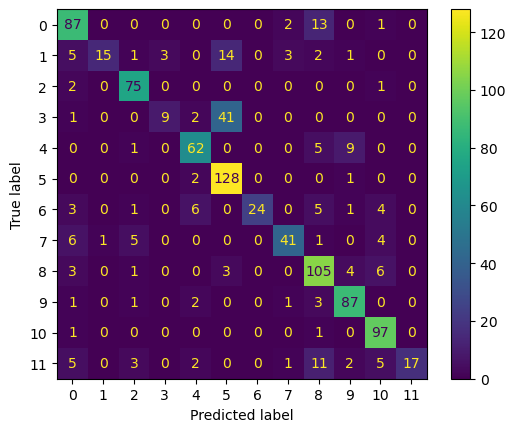

In [57]:
category_show(model_ET, x_val, y_val)

<br>
<br>

### Stacking

In [58]:
%%time

estimators = [('rf', model_rf),
              ('lgb', lgb.LGBMClassifier(learning_rate=0.1, 
                                         objective='multiclass', 
                                         num_class=12, 
                                         n_estimators=150, 
                                         max_depth=2, 
                                         n_jobs=-1)),
              ('SVC', model_SVC),
              ('SGDC', model_sgdc),
              ('ET', model_ET)
             ]

model_stack = StackingClassifier(estimators=estimators, 
                                 final_estimator= XGBClassifier(learning_rate=0.1, 
                                                                # objective='multi:softmax',
                                                                objective='multi:softproba',
                                                                num_class=12, 
                                                                n_estimators=500, 
                                                                # tree_method='gpu_hist', 
                                                                # gpu_id=0, 
                                                                max_depth=3, 
                                                                min_child_weight=3, 
                                                                max_delta_step=3, 
                                                                subsample=0.7, 
                                                                gamma=0, 
                                                                n_jobs=-1, 
                                                                use_label_encoder=False)
                                )

model_stack.fit(x_train, y_train)

score_stack = model_stack.score(x_val, y_val)
print('score_stack =', score_stack)

score_stack = 0.8957894736842106
CPU times: user 4min 21s, sys: 5.8 s, total: 4min 27s
Wall time: 2min 58s


<br>
<br>
<br>

# Predict Test Dataset

## Preprocess Images

In [59]:
def preprocessing_test_imgs(file_dir):
    """Preprocess train image by applying equalize() and then extract_seedling().
       Store the preprocessed images in train_preprocessed folder and get their class labels."""
    
    images_list = []
    img_names = os.listdir(file_dir + "test/")
    for img_name in img_names:
        img_bgr = cv2.imread(file_dir + 'test/' + img_name)
        img_equalized = equalize(img_bgr)
        img_seedling = extract_seedling(img_equalized)
        # cv2.imwrite(cls_folder + '/' + img_name, img_seedling)

        images_list.append(img_seedling)
    return images_list

In [60]:
imgs_list_test = preprocessing_test_imgs(data_dir)

In [61]:
len(imgs_list_test)

794

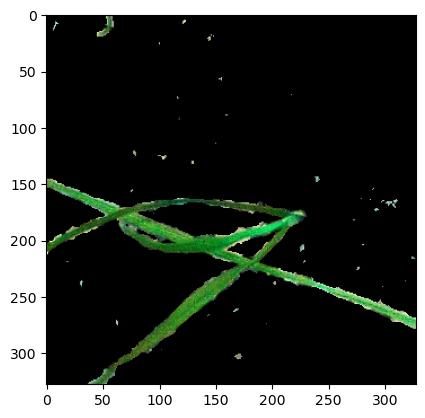

In [62]:
plt.imshow(imgs_list_test[0])
plt.show()

<br>

## SIFT + BOW
做测试的话，需要注意 bow_extractor 要沿用训练集的，而不是在测试集上重新调用 bow_init()，并且测试集也不需要提取sift特征了，因为 BOW（词袋模型）肯定是要有统一的词典才有效，主要就是要这个词典统一，如果用测试集再调用 bow_init()，词典就变了。（<a href="https://github.com/friedrichor/Plant-Seedlings-Classification" style="text-decoration:none">这段话出处</a>）

In [63]:
%%time

# feature_sift_list_test = sift_feature(imgs_list_test)  # 不需要
# bow_extractor_test = bow_init(feature_sift_list_test)  # 不需要

feature_bow_test = bow_feature(bow_extractor, imgs_list_test)  # shape = (794, 100)

100%|██████████| 794/794 [00:36<00:00, 21.76it/s]

CPU times: user 1min, sys: 7.89 s, total: 1min 8s
Wall time: 36.5 s


In [64]:
print(type(feature_bow_test), len(feature_bow_test))
feature_bow_test.shape

<class 'numpy.ndarray'> 794


(794, 100)

In [65]:
feature_bow_test[np.isnan(feature_bow_test)]    # Test for nan

array([], dtype=float32)

In [66]:
## Normalize
feature_bow_normal_test = normalize(feature_bow_test)

## Dimensionality Reduction
feature_bow_pca_test = dimensionalityReduction(feature_bow_normal_test, 100)
feature_bow_pca_test.shape

0.11656487733125687
0.17781508341431618
0.21506403014063835
0.25019053742289543
0.2793345954269171
0.30281636863946915
0.32508036121726036
0.34656660817563534
0.3663842547684908
0.3833128195255995
0.3993256278336048
0.4147933516651392
0.42993453703820705
0.44419834204018116
0.45832819677889347
0.471287127584219
0.4841242767870426
0.49652857333421707
0.5086438143625855
0.5202406207099557
0.5315331807360053
0.5426998399198055
0.5538147231563926
0.5645741717889905
0.575237519107759
0.5854343445971608
0.5954723712056875
0.6053694216534495
0.6150417681783438
0.6245472617447376
0.6337481075897813
0.6427794890478253
0.651639430783689
0.660348093137145
0.6690039280802011
0.6774793788790703
0.6859016166999936
0.6941761495545506
0.7022323841229081
0.7100903820246458
0.7178679290227592
0.72560127498582
0.7331930990330875
0.740643513854593
0.7480512280017138
0.7552621481008828
0.7623268305324018
0.7693266710266471
0.7762185800820589
0.7830630983226001
0.7897519040852785
0.7964219488203526
0.803023

(794, 100)

<br>

## HOG

In [67]:
%%time

imgs_list_test = resize_imgs(imgs_list_test)     # Resize images

feature_hog_test = hog_feature(imgs_list_test)   # (794, 100)

100%|██████████| 794/794 [00:02<00:00, 289.05it/s]

CPU times: user 2.83 s, sys: 16.1 ms, total: 2.85 s
Wall time: 2.84 s


In [68]:
feature_hog_test[np.isnan(feature_hog_test)]   # Test for nan

array([], dtype=float64)

In [69]:
## Normalize
feature_hog_normal_test = normalize(feature_hog_test)

## Dimensionality Reduction
feature_hog_pca_test = dimensionalityReduction(feature_hog_normal_test, 100)
feature_hog_pca_test.shape

0.145887490880565
0.2731265977778535
0.32884971798312873
0.3798380018602433
0.4252163859494975
0.46713358086270906
0.5050056883768768
0.5416627475260568
0.5753365181841749
0.6024877010266494
0.6229101214654209
0.6405415078812322
0.6561450480000607
0.6714976073984393
0.6849207889570583
0.697737407286322
0.7086742556714454
0.7191235302991154
0.7287516011109814
0.7381982176416874
0.7473750272189303
0.7559687198641982
0.7642708900291483
0.7720968735925856
0.7794502085990741
0.786373697469279
0.7925806509853548
0.7985161983847355
0.8041227737235889
0.8096921277190039
0.8148522799589889
0.8199733801017095
0.8245745972175039
0.8289739327116292
0.8333485841405892
0.837258844621279
0.8411306744752467
0.8448401286989214
0.8482901491024499
0.8516446440036782
0.85487659906338
0.8579864326850851
0.8610124673077146
0.8640095062946069
0.8669246510934495
0.8697610990527874
0.8724307399149351
0.8750329249885137
0.877607963602344
0.880108770073175
0.8825549673480926
0.8848835656206544
0.8871403874911307

(794, 100)

<br>

## LBP

In [70]:
## 获取 LBP 特征
feature_lbp_test = lbp_feature(imgs_list_test)     # (794, 3, 128, 128)
type(feature_lbp_test)

100%|██████████| 794/794 [00:48<00:00, 16.31it/s]


numpy.ndarray

In [71]:
## Reshape into 2 Dimensions
feature_lbp_test = feature_lbp_test.reshape(feature_lbp_test.shape[0], -1)
feature_lbp_test.shape

(794, 49152)

In [72]:
feature_lbp_test[np.isnan(feature_lbp_test)]   # Test for nan

# feature_lbp_test[np.logical_not(np.isnan(feature_lbp_test))]

array([nan, nan, nan, ..., nan, nan, nan])

In [73]:
## Fill nan with 0
feature_lbp_test = fill_missing(feature_lbp_test)
feature_lbp_test[np.isnan(feature_lbp_test)]        # Test for nan

array([], dtype=float64)

In [74]:
## Normalize
feature_lbp_normal_test = normalize(feature_lbp_test)

## Dimensionality Reduction
feature_lbp_pca_test = dimensionalityReduction(feature_lbp_normal_test, 100)
feature_lbp_pca_test.shape

0.4131915632285547
0.49642544101825414
0.566156619562063
0.6219650959005815
0.6654020623094727
0.6948396882310754
0.7179451638193796
0.735111688605941
0.7493386858582333
0.761936814772758
0.772322520126123
0.7816220745820721
0.7906220895582414
0.7987920350139829
0.8059339214288423
0.8126000315568088
0.8187125208666316
0.8246866969834231
0.8296919418624169
0.8342851392716744
0.8387023515466491
0.8427539685118663
0.8465949035461297
0.8503685928289885
0.8537109274782477
0.856947503576262
0.8600764007648661
0.8630582406784572
0.8659435618001097
0.868540853401978
0.8710627054413368
0.8734640183598389
0.8757234373292124
0.8778391221106758
0.8798764362439662
0.8818283769061408
0.8836598662342705
0.8854539353990218
0.8871788994512526
0.888876135644298
0.8904958089008395
0.8920650743747207
0.8936114429897083
0.8951073803966413
0.8965396216767394
0.8979312555413391
0.8992572373735035
0.9005530309519729
0.9018083405756112
0.9030168160726681
0.9041725318539254
0.9053068394150747
0.9064053365345801

(794, 100)

<br>

## Concatenate All Features

In [75]:
# 将 SIFT+BOW, HOG, LBP 三种特征矩阵拼合到一起
features_list_test = [feature_bow_pca_test, feature_hog_pca_test, feature_lbp_pca_test]


features_test = [[] for i in range(794)]

for feature in features_list_test:
    features_test = np.hstack((features_test, feature))
    
print(features_test.shape)

# np.save(feature_dir + 'features_test', features_test, allow_pickle=True)

(794, 300)


<br>

## Prediction

In [76]:
predict_test = model_stack.predict(features_test)

In [77]:
print(predict_test.shape)

predict_test

(794,)


array([ 5,  0,  5,  8,  9,  5,  6,  5,  0,  0,  8,  5,  8,  5,  5,  8,  8,
        5,  5,  5,  0, 11,  6,  0,  5,  5,  0,  5,  0,  8,  0,  0,  0,  6,
        0,  6,  5,  0,  5,  6,  5,  5,  0,  0,  5,  5,  5,  8, 10,  5,  6,
        5, 10,  0,  5,  5,  0,  0,  5,  5,  5,  5,  8,  4,  8,  8,  5,  0,
        0,  5,  8,  0,  8,  5,  8,  5,  5,  0,  5,  8,  0,  5, 10,  8,  8,
        8,  8,  8,  5,  5,  5,  6, 11,  5,  5,  0,  5,  0,  8,  0,  8,  5,
        6,  5,  8,  5,  0,  5,  8,  8,  5, 11,  8,  5,  0,  5,  8,  0,  8,
        5,  0,  0,  0,  0,  5,  5,  5,  8,  5,  5,  8,  5, 10,  0,  6,  6,
        9,  8, 10, 10,  9,  5, 11,  0,  6,  8,  0,  5,  5,  5, 11,  5, 11,
        5,  8,  4,  8,  8,  3,  5,  8,  8,  5,  8,  6,  0,  5, 11,  5,  0,
        0,  6,  0,  0,  5,  5,  5,  0,  5,  4,  4,  5,  0,  5,  1,  4,  5,
        5,  5,  5,  5,  6, 10, 10,  5,  0,  5,  4,  5,  5,  5,  5,  9,  8,
        8, 11,  0,  5,  5,  6,  8,  8,  4,  8,  0,  0,  8, 10,  5,  5,  6,
        8,  5,  5, 10,  8

<br>

# Submission

In [78]:
img_names = os.listdir(data_dir + "test/")

In [79]:
img_names

['fd87b36ae.png',
 '0e8492cb1.png',
 '8d6acbe9b.png',
 '54b3afd58.png',
 '6049234e6.png',
 '82b5f4d33.png',
 'a0f37c726.png',
 'e0ec5b6a1.png',
 '1cfd91582.png',
 '456d507c0.png',
 'd6d31dcbe.png',
 'e1abb4ff9.png',
 'aa7d098d1.png',
 'e19673dc9.png',
 '3e9f41817.png',
 'c88ebfb47.png',
 '59c6a9f95.png',
 '5ee9d0a5b.png',
 '0caeda5df.png',
 '862b8e7a0.png',
 '0ee4ad224.png',
 '92292055d.png',
 'dabe3e5be.png',
 '668c1007c.png',
 'fb022edf9.png',
 'd102e1a15.png',
 '5af1d74ee.png',
 '1d0cbd819.png',
 'b215531dd.png',
 'b145ba9d4.png',
 '24a058589.png',
 '6a41bf95b.png',
 '5bdcfa329.png',
 '9643fc5f4.png',
 '98d819587.png',
 '4b155fb07.png',
 'e5064f6be.png',
 '0d31e6602.png',
 'cf46d09c5.png',
 '4bbf1f6ea.png',
 '8faadb6a8.png',
 'c1ecff98b.png',
 '466bb6d3b.png',
 '3ebbe9ca4.png',
 '25fa8d109.png',
 '20e562fd5.png',
 'd14aa43f3.png',
 'cadab6616.png',
 'f25996db8.png',
 '4392d93cf.png',
 'cbe761896.png',
 'd2f0f326e.png',
 '4e9d3765f.png',
 'b3d6fdb80.png',
 '966ae5ad9.png',
 '96f14d90

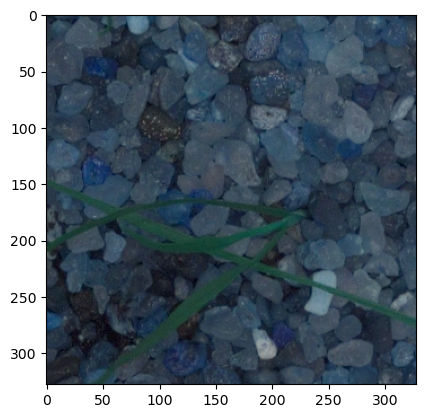

In [80]:
plt.imshow(cv2.imread(data_dir + "test/" +os.listdir(data_dir + "test/")[0]))
plt.show()

In [82]:
classes_dict

{'Scentless Mayweed': 0,
 'Common wheat': 1,
 'Charlock': 2,
 'Black-grass': 3,
 'Sugar beet': 4,
 'Loose Silky-bent': 5,
 'Maize': 6,
 'Cleavers': 7,
 'Common Chickweed': 8,
 'Fat Hen': 9,
 'Small-flowered Cranesbill': 10,
 'Shepherds Purse': 11}

In [83]:
classes_dict.keys()

dict_keys(['Scentless Mayweed', 'Common wheat', 'Charlock', 'Black-grass', 'Sugar beet', 'Loose Silky-bent', 'Maize', 'Cleavers', 'Common Chickweed', 'Fat Hen', 'Small-flowered Cranesbill', 'Shepherds Purse'])

In [86]:
num_to_class_dict = dict(zip(classes_dict.values(), classes_dict.keys()))
# num_to_class_dict 

In [87]:
predict_class = []
for pred in predict_test:
    predict_class.append(num_to_class_dict[pred])
# predict_class

<br>

## df_submission

In [88]:
df_submission = pd.DataFrame()
df_submission['file'] = img_names
df_submission['species'] = predict_class

In [89]:
df_submission.head()

,file,species
0,fd87b36ae.png,Loose Silky-bent
1,0e8492cb1.png,Scentless Mayweed
2,8d6acbe9b.png,Loose Silky-bent
3,54b3afd58.png,Common Chickweed
4,6049234e6.png,Fat Hen


In [90]:
df_submission.to_csv("./PlantSeedlingsClassificationbyML.csv", index=False)